<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/05_feature_weights_SVM_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 24 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 5s (23.2 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 121658 

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [3]:
!pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=94e5936880491469edbb0dc8432e9fb86ffdb2936b3b0c28277347d15590d451
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [6]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [ ]:
!pip install openml

In [53]:
import openml
import pandas as pd

dataset = openml.datasets.get_dataset(31, version=1.0)

print("Name:", dataset.name)
print("Description:", dataset.description)
print("Number of features:", dataset.features)
print("Number of instances:", dataset.qualities["NumberOfInstances"])


X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')
credit_risk_df = pd.concat([X, y], axis=1)

# print("DataFrame with features and labels:")
print(credit_risk_df.head())


Name: credit-g
Description: **Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of 

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


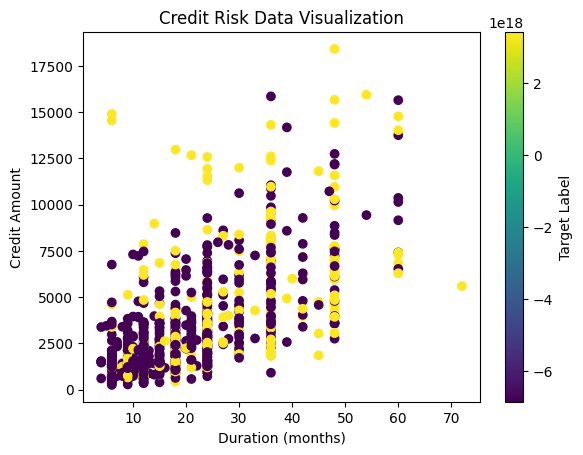

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

duration_col = "duration"
credit_amount_col = "credit_amount"
target_col = "class"


credit_risk_df['target_encoded'] = credit_risk_df[target_col].apply(hash)

plt.scatter(credit_risk_df[duration_col], credit_risk_df[credit_amount_col], c=credit_risk_df['target_encoded'], cmap='viridis', marker='o')

plt.xlabel("Duration (months)")
plt.ylabel("Credit Amount")
plt.title("Credit Risk Data Visualization")

plt.colorbar(label="Target Label")

plt.show()



In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, IndexToString, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.sql.functions import col

@spark_sql_initializer
def train_SVG(spark, df):
    credit_risk_df = spark.createDataFrame(df)
    credit_risk_df.show()

    index_columns = credit_risk_df.columns[:-1]
    credit_risk_df = credit_risk_df.withColumnRenamed("class", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        credit_risk_df = indexer.fit(credit_risk_df).transform(credit_risk_df)

    feature_encoders = [OneHotEncoder(inputCol=f"indexed_{col}", outputCol=f"encoded_{col}") for col in index_columns]
    for encoder in feature_encoders:
            credit_risk_df = encoder.fit(credit_risk_df).transform(credit_risk_df)

    vector_assembler = VectorAssembler(
        inputCols=list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)), outputCol="features")
    # credit_risk_df = vector_assembler.transform(credit_risk_df)
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))
    # credit_risk_df.show()

    label_indexer = StringIndexer(inputCol="label", outputCol="indexed_label").fit(credit_risk_df)
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

    svm_classifier = LinearSVC(labelCol="indexed_label", featuresCol="features")

    training_data, test_data = credit_risk_df.randomSplit([0.7, 0.3], seed=1122)

    svm_pipeline = Pipeline(
        stages=feature_indexes + feature_encoders + [vector_assembler, label_indexer, svm_classifier, label_converter])
    svm_model = svm_pipeline.fit(training_data)

    svm_prediction = svm_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(svm_prediction)
    print("Test Accuracy = {:.2%}".format(accuracy))

    svm_prediction.select("label", "predictedLabel").show()


    feature_weights = svm_model.stages[-2].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [55]:
%%time

credit_risk_df_SVG = credit_risk_df.copy()
train_SVG(credit_risk_df_SVG)

+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|checking_status|duration|      credit_history|            purpose|credit_amount|  savings_status|employment|installment_commitment|   personal_status|other_parties|residence_since|property_magnitude|age|other_payment_plans| housing|existing_credits|                 job|num_dependents|own_telephone|foreign_worker|class|
+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|             <0|       6|critical

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, IndexToString, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.sql.functions import col

@spark_sql_initializer
def train_SVG_2(spark, df):
    credit_risk_df = spark.createDataFrame(df)
    credit_risk_df.show()

    index_columns = credit_risk_df.columns[:-1]
    credit_risk_df = credit_risk_df.withColumnRenamed("class", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        credit_risk_df = indexer.fit(credit_risk_df).transform(credit_risk_df)

    vector_assembler = VectorAssembler(
        inputCols=list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)), outputCol="features")
    # credit_risk_df = vector_assembler.transform(credit_risk_df)
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))
    # credit_risk_df.show()

    label_indexer = StringIndexer(inputCol="label", outputCol="indexed_label").fit(credit_risk_df)
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

    svm_classifier = LinearSVC(labelCol="indexed_label", featuresCol="features")

    training_data, test_data = credit_risk_df.randomSplit([0.7, 0.3], seed=1122)

    svm_pipeline = Pipeline(
        stages=feature_indexes + [vector_assembler, label_indexer, svm_classifier, label_converter])
    svm_model = svm_pipeline.fit(training_data)

    svm_prediction = svm_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(svm_prediction)
    print("Test Accuracy = {:.2%}".format(accuracy))

    svm_prediction.select("label", "predictedLabel").show()


    feature_weights = svm_model.stages[-2].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [78]:
%%time

credit_risk_df_GBT = credit_risk_df.copy()
train_SVG_2(credit_risk_df_GBT)

+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|checking_status|duration|      credit_history|            purpose|credit_amount|  savings_status|employment|installment_commitment|   personal_status|other_parties|residence_since|property_magnitude|age|other_payment_plans| housing|existing_credits|                 job|num_dependents|own_telephone|foreign_worker|class|
+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|             <0|       6|critical

In [98]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler, IndexToString, StringIndexer, ChiSqSelector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.sql.functions import col

@spark_sql_initializer
def train_ChiSq(spark, df):
    credit_risk_df = spark.createDataFrame(df)
    credit_risk_df.show()

    index_columns = credit_risk_df.columns[:-1]
    credit_risk_df = credit_risk_df.withColumnRenamed("class", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        credit_risk_df = indexer.fit(credit_risk_df).transform(credit_risk_df)

    vector_assembler = VectorAssembler(
        inputCols=list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)), outputCol="features")
    # credit_risk_df = vector_assembler.transform(credit_risk_df)
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))
    # credit_risk_df.show()

    label_indexer = StringIndexer(inputCol="label", outputCol="indexed_label").fit(credit_risk_df)
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

    selector = ChiSqSelector(numTopFeatures=6, featuresCol="features", outputCol="selected_features", labelCol="indexed_label")

    svm_classifier = LinearSVC(labelCol="indexed_label", featuresCol="selected_features")

    training_data, test_data = credit_risk_df.randomSplit([0.7, 0.3], seed=1122)

    svm_pipeline = Pipeline(
        stages=feature_indexes + [vector_assembler, label_indexer, selector, svm_classifier, label_converter])
    svm_model = svm_pipeline.fit(training_data)

    svm_prediction = svm_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(svm_prediction)
    print("Test Accuracy = {:.2%}".format(accuracy))

    svm_prediction.select("label", "predictedLabel").show()

    feature_weights = svm_model.stages[-2].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [99]:
%%time

credit_risk_df_CS = credit_risk_df.copy()
train_ChiSq(credit_risk_df_CS)

+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|checking_status|duration|      credit_history|            purpose|credit_amount|  savings_status|employment|installment_commitment|   personal_status|other_parties|residence_since|property_magnitude|age|other_payment_plans| housing|existing_credits|                 job|num_dependents|own_telephone|foreign_worker|class|
+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|             <0|       6|critical

In [96]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler, IndexToString, StringIndexer, PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.sql.functions import col

@spark_sql_initializer
def train_PCA(spark, df):
    credit_risk_df = spark.createDataFrame(df)
    credit_risk_df.show()

    index_columns = credit_risk_df.columns[:-1]
    credit_risk_df = credit_risk_df.withColumnRenamed("class", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        credit_risk_df = indexer.fit(credit_risk_df).transform(credit_risk_df)

    vector_assembler = VectorAssembler(
        inputCols=list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)), outputCol="features")
    # credit_risk_df = vector_assembler.transform(credit_risk_df)
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))
    credit_risk_df = credit_risk_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))
    # credit_risk_df.show()

    pca = PCA(k=6, inputCol="features", outputCol="pca_features")

    label_indexer = StringIndexer(inputCol="label", outputCol="indexed_label").fit(credit_risk_df)
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

    svm_classifier = LinearSVC(labelCol="indexed_label", featuresCol="pca_features")

    training_data, test_data = credit_risk_df.randomSplit([0.7, 0.3], seed=1122)

    svm_pipeline = Pipeline(
        stages=feature_indexes + [vector_assembler, pca, label_indexer, svm_classifier, label_converter])
    svm_model = svm_pipeline.fit(training_data)

    svm_prediction = svm_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(svm_prediction)
    print("Test Accuracy = {:.2%}".format(accuracy))

    svm_prediction.select("label", "predictedLabel").show()

    feature_weights = svm_model.stages[-2].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [97]:
%%time

credit_risk_df_PCA = credit_risk_df.copy()
train_PCA(credit_risk_df_PCA)

+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|checking_status|duration|      credit_history|            purpose|credit_amount|  savings_status|employment|installment_commitment|   personal_status|other_parties|residence_since|property_magnitude|age|other_payment_plans| housing|existing_credits|                 job|num_dependents|own_telephone|foreign_worker|class|
+---------------+--------+--------------------+-------------------+-------------+----------------+----------+----------------------+------------------+-------------+---------------+------------------+---+-------------------+--------+----------------+--------------------+--------------+-------------+--------------+-----+
|             <0|       6|critical